In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

from netgen.geom2d import CSG2d , Rectangle , Circle
from ngsolve import *
from ngsolve.webgui import Draw

importing NGSolve-6.2.2204


# Aufgabe 1 Dirichlet Randbedingung

## Ausgangslage und schwache Gleichung

Aus der starken Gleichung mit homogener Dirichlet Randbedingung

$$
\begin{align} \frac{\partial^2 p}{\partial t^2}(t,x)-c^2\Delta p(t,x) &= b(t,x)\hspace{20pt} \mathrm{in}\ \Omega\\
u(0,x) &= 0\hspace{20pt} \mathrm{in}\ \Omega\\
\dot{u}(0,x) &= 0\hspace{20pt} \mathrm{in}\ \Omega\\
u(t,x) &= 0\hspace{20pt} \mathrm{auf}\ \Gamma_D\\
b(t,x) &= \sum_i q_i(t)\cdot e^{-\frac{(\mathbf{x-x}_i)^2}{\sigma^2}}
\end{align}$$

folgt mithilfe der partiellen Integration die schwache Gleichung

$$
\begin{align}
\int_\Omega c^2\nabla p\nabla v dx-\underbrace{\int_{\partial \Omega}c^2 \partial_n p\cdot v dS}_{v = 0\ \mathrm{auf}\ \Gamma_D}+\int_\Omega \partial _{tt} p\cdot v dx &= \int_\Omega b\cdot v dx\hspace{8pt} \forall v \in V.\\
\end{align}$$


## Geometrie und Mesh

Die Schallausbreitung soll in einer Kirche mit folgender Geometrie simuliert werden:

In [ ]:
#Geometrie Kirche
rect = Rectangle (( -6 , -20) ,(6 ,0) , bc='wall')
circle = Circle ((0 ,0) ,3 , bc='wall')
hall = rect + circle

#Säulen
saeulen = []
nSaeulenReihen = 4
for i in range ( nSaeulenReihen ):
    saeulen.append ( Circle (( -2. , -20./( nSaeulenReihen +1)*( i+1)) ,0.6 , bc='saeule'))
    saeulen.append ( Circle ((2. , -20./( nSaeulenReihen +1)*( i+1)) ,0.6 , bc='saeule'))
for s in saeulen :
    hall -=s

geo = CSG2d ()
geo.Add ( hall )


Das Mesh soll so gewählt werden, dass jede Wellenlänge mit 5 Knotenpunkten aufgelöst wird. Die maximale Elementgrösse $h_{max}$ kann mit

$$ \begin{align} h_{max}=\frac{c_0}{5\cdot f_{max}} \end{align}$$

berechnet werden, wobei $c_0$ die Schallausbreitungsgeschwindigkeit in der Luft und $f_{max}$ die maximal auftretende Frequenz beschreibt. Diese Wahl basiert darauf, dass Basisfunktionen 2. Ordnung gewählt werden.

In [ ]:
#Frequenzabhängiges Mesh
freq = 200
c0 = 333 
maxh = c0/freq/5
mesh = Mesh(geo.GenerateMesh(maxh = maxh))
Draw(mesh)

## Vektorraum
Als Vektorraum wird der $H^1$-FE Raum mit Basisfunktionen zweiter Ordnung gewählt. Anschliessend werden die Test- und Trial-Funkionen erstellt. Da in der schwachen Gleichung ein Term mit zweiter zeitlicher Ableitung vorhanden ist, müssen, zusätzlich zur Grid-Function für die Position, Grid-Funktionen für die Schallschnelle und deren Ableitung definiert werden.

In [ ]:
V1 = H1(mesh,order = 2, dirichlet='wall|saeule')
u1,v1 = V1.TnT()                               #Test and trial

gfu1 = GridFunction(V1)
gfv1 = GridFunction(V1)                       # 1. Zeitableitung
gfa1 = GridFunction(V1)                       # 2. Zeitableitung
print('Freiheitsgrade:',V1.ndof)

## Newmark Verfahren
Für das Newmark Verfahren kann die schwache Gleichung in die Form 

$$
\begin{align}
\mathbf{M}\ddot{d}+\mathbf{C}\dot{d}+\mathbf{K}d &= \mathbf{F}\\
\mathbf{K}d &= \int_\Omega c_0\nabla p\nabla v\ dx\\
\mathbf{C}\dot{d} &= 0\\
\mathbf{M}\ddot{d} &= \int_\Omega \partial_{tt}p\cdot v\ dx
\end{align}$$
gebracht werden. $\mathbf{M}$ beschreibt die Massenmtrix, $\mathbf{C}$ die viskose Dämpfung (in diesem Beispiel nicht vorhanden), $\mathbf{K}$ die Steifigkeitsmatrix und $\mathbf{F}$ einen Vektor mit den verwendeten Quellen.

Anschliessend können die Billinearformen $\mathbf{M}$ und $\mathbf{K}$ und die Linearform $\mathbf{F}$ assembliert werden.

In [ ]:
#Steifigkeitsmatrix
K1 = BilinearForm(V1)         
K1 += c0**2*grad(u1)*grad(v1)*dx
K1.Assemble()

#Massenmatrix
M1 = BilinearForm(V1)
M1 += u1*v1*dx
M1.Assemble();

#Rechte Seite (Monopolquellen)
x0= np.array([0,1])
y0= np.array([0,1])
q0 = np.array([1e7, 1e7])                                        #nicht zu klein wählen
sigma =  np.array([0.3, 0.3])
f1 = sum(q0[i]*exp(-((x-x0[i])**2+(y-y0[i])**2)/sigma[i]**2) for i in range(0,len(x0)))

F1 = LinearForm(V1)
F1 += f1*v1*dx
F1.Assemble();

In [43]:
def solveNewmark(V, gfu, gfv, gfa, F, K, M, mesh, scene, dt, n = 400, impuls = True):
    #Trapezverfahren
    beta = 1/4
    gamma = 1/2
    
    mstar = K.mat.CreateMatrix()                                                #Neue Matrix
    mstar.AsVector().data = M.mat.AsVector() + beta*dt**2 * K.mat.AsVector()    #M*
    
    # Zeitbereich
    t = 0
    gfu.vec[:] = 0
    gfv.vec[:] = 0
    gfa.vec[:] = 0
    T = n*dt
    
    # predictors
    utilde = gfu.vec.CreateVector()
    vtilde = gfu.vec.CreateVector()
    b = gfu.vec.CreateVector()
    mip = mesh(0,0)
    ui = [gfu(mip)]
    ti = [t]
    i = 0
    p = np.zeros((n,3))
    with TaskManager():
        while t < T:
            #F.Assemble() # muss bei zeitabhängiger Linearform aufgerufen werden.
            # predictors berechnnen
            utilde.data = gfu.vec + dt * gfv.vec + dt**2/2*(1-2*beta)*gfa.vec
            vtilde.data = gfv.vec + (1-gamma)*dt*gfa.vec
            
            # a neu berechnen
            if impuls and t > 1/(2*freq):
                b.data = - K.mat*utilde
            else:
                b.data = F.vec
                b.data *= np.sin(2*np.pi*freq*t)**2
                b.data -= K.mat*utilde
                
            gfa.vec.data = mstar.Inverse(freedofs=V.FreeDofs(),inverse='sparsecholesky')*b
            
            # corrector berechnen
            gfu.vec.data = utilde + beta*dt**2*gfa.vec
            gfv.vec.data = vtilde + gamma*dt*gfa.vec
            
            # Redraw
            scene.Redraw()
            ui.append(gfu(mip))
            ti.append(t)
            t+=dt

            #Funktionswerte
            p[i,0]=gfu(mesh(0,0))
            p[i,1]=gfu(mesh(0,-2))
            p[i,2]=gfu(mesh(0,-8))
            i += 1
    return p
    

## Anfangsbedingung
Die Ausgangslage zum Zeitpunkt $t=0$ sieht wie folgt aus:

In [ ]:
Draw(f1,mesh,'f')

## Zeitabhängige Lösung mit Trapezmethode

In [ ]:
dt=1/(10*freq)*2/4
n = 400

In [ ]:
scene1 = Draw(gfu1,mesh,'u',min = -2, max = 2,autoscale=False)

In [ ]:
p1 = solveNewmark(V1, gfu1, gfv1, gfa1, F1, K1, M1, mesh, scene1, dt, n)

### Schalldruckmessungen im Raum
Für beliebige Punkte im Raum kann der Schalldruck für die simulierten Zeitpunkte gemessen und dargestellt werden.

In [ ]:
fig1, ax1 = plt.subplots(1,3,figsize = (9,3))

for i in range(0,3):
    ax1[i].plot(p1[:,i])
    ax1[i].set(xlabel = "Step", ylabel = "p [$N/m^2}$]")
    ax1[i].grid()


# Aufgabe 2 Robin Randbedingung

## Schwache Gleichung mit Robin Randbedingung

Mit der Robin Randbedingung

$$
\begin{align}
\partial_n p(t,x) = - \alpha\cdot p(t,x)
\end{align}
$$

kann die schwache Gleichung von 

$$
\begin{align}
\int_\Omega c^2\nabla p\nabla v dx-\int_{\partial \Omega}c^2 \partial_n p\cdot v dS+\int_\Omega \partial _{tt} p\cdot v dx &= \int_\Omega b\cdot v dx\hspace{8pt} \forall v \in V.\\
\end{align}
$$

in 

$$
\begin{align}
\int_\Omega c^2\nabla p\nabla v dx-\int_{\partial \Omega}\alpha c^2 p\cdot v dS+\int_\Omega \partial _{tt} p\cdot v dx &= \int_\Omega b\cdot v dx\hspace{8pt} \forall v \in V.\\
\end{align}
$$

umgeschrieben werden.

## Randbedingungen und Vektorraum
Bei diesem Beispiel sollen die Robin Randbedingungen auf den Wänden und Säulen der Kirche angewendet werden.

In [ ]:
#mesh.GetBoundaries();

Wie beim ersten Beispiel wird auch hier ein $H^1$-FE Raum zweiter Ordnung verwendet.

In [ ]:
V2 = H1(mesh,order = 2)
u2,v2 = V2.TnT()                               #Test and trial

gfu2 = GridFunction(V2)
gfv2 = GridFunction(V2)                       # 1. Zeitableitung
gfa2 = GridFunction(V2)                       # 2. Zeitableitung
print('Freiheitsgrade:',V2.ndof)

## Newmark Verfahren
Auch hier wird wieder das oben genannte Newmark Verfahren angewendet.

In [ ]:
alpha = 0.1                      #bei grossen alpha nähert sich die robin randbedingung einer homogenen Dirichlet
#Steifigkeitsmatrix
K2 = BilinearForm(V2)         
K2 += c0**2*grad(u2)*grad(v2)*dx
K2 += alpha*c0**(2)*u2*v2*ds(definedon=mesh.Boundaries('wall|saeule'))         #Robin Randbedingung
K2.Assemble()

#Massenmatrix
M2 = BilinearForm(V2)
M2 += u2*v2*dx
M2.Assemble();

#Rechte Seite (Monopolquellen)
x0= np.array([0,1])
y0= np.array([0,1])
q0 = np.array([1e7, 1e7])                                        #nicht zu klein wählen
sigma =  np.array([0.3, 0.3])
f2 = sum(q0[i]*exp(-((x-x0[i])**2+(y-y0[i])**2)/sigma[i]**2) for i in range(0,len(x0)))

F2 = LinearForm(V2)
F2 += f2*v2*dx
F2.Assemble();

## Anfangsbedingung
Die Ausgangslage zum Zeitpunkt $t=0$ sieht wie folgt aus:

In [ ]:
Draw(f2,mesh,'f')

## Zeitabhängige Lösung mit Trapezmethode

In [ ]:
dt=1/(10*freq)*2/4
n = 400

In [ ]:
scene2 = Draw(gfu2,mesh,'u',min = -2, max = 2,autoscale=False)

In [ ]:
p2 = solveNewmark(V2, gfu2, gfv2, gfa2, F2, K2, M2, mesh, scene2, dt, n)

### Schalldruckmessungen im Raum
Für beliebige Punkte im Raum kann der Schalldruck für die simulierten Zeitpunkte gemessen und dargestellt werden.

In [ ]:
fig2, ax2 = plt.subplots(1,3,figsize = (9,3))

for i in range(0,3):
    ax2[i].plot(p1[:,i], label = "Reine Dirichlet RB")
    ax2[i].plot(p2[:,i], label = "Robin RB")
    ax2[i].set(xlabel = "Step")
    ax2[i].grid()
ax2[2].legend(bbox_to_anchor=(1.1, 1.0))
ax2[0].set(ylabel = "p [$N/m^2}$]");


# Aufgabe 3 Harmonische Lösung

## Schwache Gleichung im Frequenzbereich

### Harmonischer Ansatz

Für das Ausgangsproblem
$$
\begin{align} 
\frac{\partial^2 p}{\partial t^2}(t,x)-c^2\Delta p(t,x) &= b(t,x)\hspace{20pt} \mathrm{in}\ \Omega\\
\end{align}
$$
können Zeit und Ort separiert werden durch den Ansatz für die Lösung:
$$
\begin{align}
    p(t,x)=e^{j\omega t}\tilde{p}(x)\\
\end{align}
$$
Dabei ist $p(t,x)$ wegen der Multiplikation mit $e^{j\omega t}$ ein komplexer Zeiger, welcher eine harmonische Schwingung über eine Periodendauer $\frac{2\pi}{\omega}$ darstellen kann. Die eigentliche Lösung wird durch die Komplexe Zahl $\tilde{p}(x)$ beschrieben. Ein komplexer Zeiger könnte auch über einen reellen Skalar und Multiplikation mit $e^{j\omega t}$ beschrieben werden, jedoch ist die gesuchte Lösung eine Schwingung mit Anfangsauslenkung $\varphi_{0}$, welche als 
$$
\begin{align}
    \tilde{p}(x) = x_{0}+iy_{0} = |\tilde{p}(x)|\cdot e^{j\varphi_{0}}
\end{align}
$$
beschrieben wird, weshalb $p(t,x)$ auch als

$$
\begin{align}
    p(t,x)=|\tilde{p}(x)|\cdot e^{j(\omega t + \varphi_{0})}
\end{align}
$$

geschrieben werden kann.


Mit dem Ansatz für die Anregung
$$
\begin{align}
b(t,x)=\sum_{i} {e^{j\omega t} e^{-\frac{(x-x_{i})}{\sigma^2}}}
\end{align}
$$

kann schliesslich die harmonische Lösung im Frequenzraum gefunden werden.

### Formulierung der DGL

Es werden $p(t,x)$ und $b(t,x)$ in die gegebene Schallgleichung eingesetzt:

$$
\begin{align} 
\frac{\partial^2}{\partial t^2} \left[ e^{j\omega t}\tilde{p}(x)\right] -c^2\Delta \left[ e^{j\omega t}\tilde{p}(x)\right] &= b(t,x)=\sum_{i} {e^{j\omega t} e^{-\frac{(x-x_{i})}{\sigma^2}}}
\end{align}
$$

Durch Anwendung der doppelten zeitlichen Ableitung und des Laplace-Operators folgt:

$$
\begin{align} 
- \omega ^2 e^{j\omega t} \tilde{p}(x)- c^2 e^{j\omega t} \Delta \tilde{p}(x) = e^{j\omega t} \sum_{i} {e^{-\frac{(x-x_{i})}{\sigma^2}}}
\end{align}
$$

wobei $e^{j\omega t}$ als ortsabhängige Funktion vor den Laplace-Operator gezogen werden darf und vor die Summe geschrieben werden kann, da $e^{j\omega t}$ unabhängig von der Summenvariable $i$ ist. Durch Kürzen folgt die Differentialgleichung im Frequenzbereich:

$$
\begin{align} 
- \omega ^2 \tilde{p}(x)- c^2 \Delta \tilde{p}(x) =\sum_{i} {e^{-\frac{(x-x_{i})}{\sigma^2}}}
\end{align}
$$

mit der Robin Randbedingung

$$
\begin{align}
\partial_n \tilde{p}(x) = - \alpha\cdot \tilde{p}(x)
\end{align}
$$

### Schwache Gleichung

Multiplikation mit der Testfunktion $\tilde{v}$, Integration über den ganzen Raum und Anwendung der partiellen Integration liefert Ausgangsform für die schwache Gleichung:


$$
\begin{align}
\int_\Omega c^2 \cdot \nabla \tilde{p} \cdot \nabla \tilde{v}dx
-\int_{\Omega} \omega^{2} \cdot \tilde{p} \cdot \tilde{v} dx
-\int_{\partial\Omega} c^{2} \cdot \partial_{n} \tilde{p} \cdot \tilde{v} dS
= \int_{\Omega}\sum_{i} e^{- \frac{(x-x_{i})^2}{\sigma^2}} \cdot \tilde{v} dx
\end{align}
$$
mit der Robin-Randbedingung:
$$
\begin{align}
    \int_{\partial \Omega} \partial_{n} \tilde{p} \cdot \tilde{v} dS 
    = -\int_{\partial \Omega} \alpha \cdot \tilde{p} \cdot \tilde{v}dS
\end{align}
$$
und schliesslich:
$$
\begin{align}
\int_\Omega c^2 \cdot \nabla \tilde{p} \cdot \nabla \tilde{v}dx
-\int_{\Omega} \omega^{2} \cdot \tilde{p} \cdot \tilde{v} dx
+\int_{\partial\Omega} c^{2} \alpha \cdot \tilde{p} \cdot \tilde{v} dS
=\int_{\Omega}\sum_{i}  e^{- \frac{(x-x_{i})^2}{\sigma^2}} \cdot \tilde{v} dx
\end{align}
$$

## Assembling und Lösungsfunktion
Die Billinear- und Linearfrom werden gemäss schwacher Gleichung assembliert:

In [152]:
def solveHarmonic(gfu_h, V_h, v_h, u_h, mesh_h, omega_h, alpha_h, f_h):    
    with TaskManager():
        # Bilinearfrom
        A_h = BilinearForm(V_h)         
        A_h += c0**2*grad(u_h)*grad(v_h)*dx
        A_h += -omega_h**2*u_h*v_h*dx
        A_h += c0**2*1j*omega_h*alpha_h*u_h*v_h*ds(definedon=mesh_h.Boundaries('wall'))   #Robin-Randbedingung (für komplexes alpha werden die Lösungen komplexwertig)
        A_h.Assemble()

        # Linearform (Monopolquellen)
        F_h = LinearForm(V_h)
        F_h += f_h*v_h*dx#('interior')
        F_h.Assemble();

        # Lösung
        gfu_h.vec.data = A_h.mat.Inverse(freedofs=V_h.FreeDofs(), inverse='sparsecholesky')*F_h.vec

    return gfu_h

## Geometrie und Perfectly Matched Layer

In der harmonischen Lösung kann es bei harten Randbedingungen zu einer "Flutung" des Raumes mit Schall kommen. Um dies vorzubeugen lohnt es sich, ein "perfectly matched layer" einzusetzen. Dieses PML kann vereinfacht als unendlich ausgedehnter Raum interpretiert werden. Wählt man beispielsweise eine rechteckige PML Region, am unteren Ende der Kirche, so hat dies denselben Effekt wie eine offene Tür.

In [23]:
from netgen.occ import OCCGeometry, Rectangle, Circle, MoveTo, Glue

rect = MoveTo(-6,-20).Rectangle(12,20).Face()
circle = Circle((0,0),3).Face()
hall = rect+circle
saeulen = []
nSaeulenReihen = 4
for i in range(nSaeulenReihen):
    saeulen.append(Circle((-2.,-20./(nSaeulenReihen+1)*(i+1)),0.6).Face())
    saeulen.append(Circle((2.,-20./(nSaeulenReihen+1)*(i+1)),0.6).Face())
for s in saeulen:
    hall -= s
    
rectPML = MoveTo(-3,-22).Rectangle(6,2).Face()

#edges
hall.edges.name = 'wall'
rectPML.edges.name = 'wall'
rectPML.edges.Nearest((0,-20)).name = 'interior'

#faces
hall.faces.name = 'interior'
rectPML.faces.name = 'PMLRegion'

geo = OCCGeometry(Glue([hall, rectPML]), dim=2)

## Randbedingungen und Vektorraum
Bei diesem Beispiel sollen die Robin Randbedingungen auf den Wänden und Säulen der Kirche angewendet werden.
Wie beim ersten Beispiel wird auch hier ein $H^1$-FE Raum zweiter Ordnung verwendet, jedoch muss hier wegen dem harmonischen Ansatz das complex-Attribut auf "True" gesetzt werden.

In [24]:
# Default-Parameter
c0 = 333.
f_max = 250
f_min = c0/12                       #Wellenlänge kleiner als Raumbreite

freq = f_max
omega_0 = 2*np.pi*freq


# Mesh
maxh = c0*2*np.pi/omega_0/5
mesh = Mesh(geo.GenerateMesh(maxh = maxh))
mesh.Curve(3)

### Perfectly Matched Layer (PML)

In [25]:
from ngsolve.comp import pml

mesh.SetPML(pml.Cartesian(mins = [-3, -20], maxs = [3, -22],alpha=1j), "PMLRegion")

In [26]:
#mesh.GetMaterials()

In [27]:
#mesh.GetBoundaries()

In [28]:
V3 = H1(mesh,order = 2, complex = True)
u3,v3 = V3.TnT()          #Test and trial
print('Freiheitsgrade:',V3.ndof)

Freiheitsgrade: 15173


## Anfangswert

In [29]:
x0= np.array([0,0])
y0= np.array([0,-7])
q0 = np.array([1e7, 1e7])                                        #nicht zu klein wählen
sigma =  np.array([0.3, 0.5])
f3 = sum(q0[i]*exp(-((x-x0[i])**2+(y-y0[i])**2)/sigma[i]**2) for i in range(0,len(x0)))

Draw(f3,mesh,'f3')

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.22…

BaseWebGuiScene

## Lösung für verschiedene Parameter

### Sweep über $\alpha$

Mit einem Sweep über den Parameter $\alpha$ kann die Gewichtung zwischen Dirichlet- und Neumann-Anteil der Robin Randbedingung
$$
\begin{align}
\partial_n \tilde{p}(x) + i\omega\cdot\alpha\cdot \tilde{p}(x) = 0 
\end{align}
$$
variiert werden. 

Für sehr grosse $\alpha$ gewinnt der Term $\tilde{p}(x)$ mit der Funktion selber Überhand und wird somit auf dem Rand gleich Null. Dies entspricht homogenen Dirichlet-Randwerten und kann als festes Ende der Schwingung verstanden werden.
$$
\begin{align}
i\omega\cdot\alpha\cdot \tilde{p}(x) \approx 0 
\end{align}
$$

Lassen wir $\alpha$ gegen Null streben, so gewinnt die Normalenableitung die Überhand und wird auf den Rand Null, was einem homogenen Neumann-Rand entspricht. Somit ist die Steigung der Lösungsfuktion auf dem Rand Null, der Funktioswert an sich jedoch im allgemeinen nicht. Dies entspricht einem Ende, welches bis auf die Steigung frei schwingen kann.
$$
\begin{align}
\partial_n \tilde{p}(x) \approx 0 
\end{align}
$$

In [30]:
gfu3 = GridFunction(V3)
p3_sol = []

scene = Draw(gfu3,mesh,'u', autoscale=True)
time.sleep(1)

# alpha kann reellwertig gewählt werden, *1j in Funktion implementiert
for alpha in np.array([100,10,1,0.8,0.5,0.2,0.1,0.05,0.03])/omega_0:
    gfu3 = solveHarmonic(gfu3, V3, v3, u3,mesh, omega_0, alpha, f3)
  
    p3_sol.append(gfu3(mesh(5,-10)))
    
    scene.Redraw()
        
    time.sleep(0.5)


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.22…

#### Schalldruckmessungen

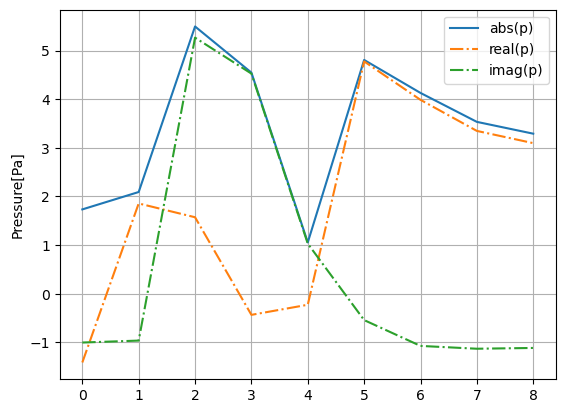

In [31]:
p3_arr = np.zeros(len(p3_sol), dtype = np.complex_);
p3_arr = np.asarray(p3_sol);

plt.figure(1)
plt.plot(abs(p3_arr), label = "abs(p)")
plt.plot(np.real(p3_arr), "-.", label = "real(p)")
plt.plot(np.imag(p3_arr), "-.", label = "imag(p)")
plt.grid()
plt.legend()
plt.ylabel("Pressure[Pa]")
plt.show()


### Sweep für die Frequenz (eingeschwungener Zustand)

In [32]:
gfu3 = GridFunction(V3)

# alpha kann reellwertig gewählt werden, *1j in Funktion implementiert
alpha_0 = 0.1/omega_0

omega =  2*np.pi*np.linspace(f_min,f_max,10).astype(int)

scene = Draw(gfu3,mesh,'u', autoscale=True)
time.sleep(1)

p_int = []

for omegai in omega:
    gfu3 = solveHarmonic(gfu3, V3, v3, u3,mesh, omegai, alpha_0, f3)    # solve
    scene.Redraw()
    
    time.sleep(0.2)
    
    # Integration des Druckes
    p_int.append(Integrate(gfu3.real**2,mesh)**(0.5))
    

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.22…

#### Spektrum der 2-Norm des Schalldrucks 

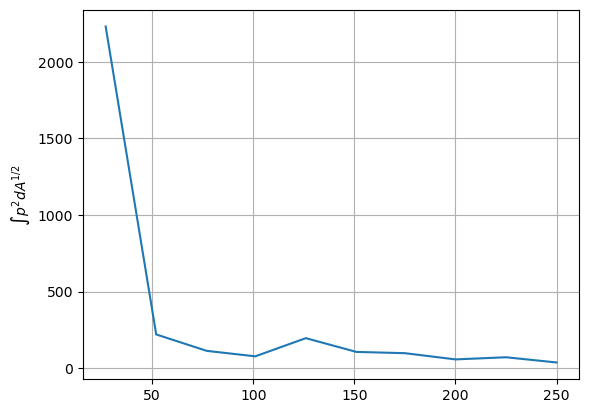

In [33]:
plt.plot(omega/(2*np.pi),p_int)
plt.grid()
plt.ylabel("∫$p^2dA ^{1/2}$")
plt.show()

#### Auswertung einer spezifischen Frequenz

In [34]:
gfu3 = GridFunction(V3)
freq = 100
omega = 2*np.pi*freq
alpha = 0.1/omega
gfu3 = solveHarmonic(gfu3, V3, v3, u3, mesh, omega,alpha, f3)
Draw(gfu3, mesh)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.22…

BaseWebGuiScene

# Vergleich mit Lösung im Zeitbereich

In [141]:
from netgen.geom2d import CSG2d , Rectangle , Circle
#Geometrie Kirche
rect = Rectangle (( -6 , -20) ,(6 ,0) , bc='wall')
circle = Circle ((0 ,0) ,3 , bc='wall')
hall = rect + circle

#Säulen
saeulen = []
nSaeulenReihen = 4
for i in range ( nSaeulenReihen ):
    saeulen.append ( Circle (( -2. , -20./( nSaeulenReihen +1)*( i+1)) ,0.6 , bc='wall'))
    saeulen.append ( Circle ((2. , -20./( nSaeulenReihen +1)*( i+1)) ,0.6 , bc='wall'))
for s in saeulen :
    hall -=s

geo = CSG2d ()
geo.Add ( hall )

In [142]:
#Frequenzabhängiges Mesh
freq = 100
c0 = 333 
maxh = c0/freq/10
mesh4 = Mesh(geo.GenerateMesh(maxh = maxh))
Draw(mesh4)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.22…

BaseWebGuiScene

In [143]:
V4 = H1(mesh4,order = 2)
u4,v4 = V4.TnT()                               #Test and trial

gfu4 = GridFunction(V4)
gfv4 = GridFunction(V4)                       # 1. Zeitableitung
gfa4 = GridFunction(V4)                       # 2. Zeitableitung
print('Freiheitsgrade:',V4.ndof)

Freiheitsgrade: 9783


In [144]:
alpha4 = 4                     #bei grossen alpha nähert sich die robin randbedingung einer homogenen Dirichlet
#Steifigkeitsmatrix
K4 = BilinearForm(V4)         
K4 += c0**2*grad(u4)*grad(v4)*dx
K4 += alpha4*c0**(2)*u4*v4*ds(definedon=mesh4.Boundaries('wall'))         #Robin Randbedingung
K4.Assemble()

#Massenmatrix
M4 = BilinearForm(V4)
M4 += u4*v4*dx
M4.Assemble();

#Rechte Seite (Monopolquellen)
x0= np.array([0])
y0= np.array([0])
q0 = np.array([1e7])                                        #nicht zu klein wählen
sigma =  np.array([0.3])
f4 = sum(q0[i]*exp(-((x-x0[i])**2+(y-y0[i])**2)/sigma[i]**2) for i in range(0,len(x0)))

F4 = LinearForm(V4)
F4 += f4*v4*dx
F4.Assemble();

In [145]:
Draw(f4,mesh4,'f')

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.22…

BaseWebGuiScene

In [146]:
dt4=1/(10*freq)*2/10
n4 = 1000
dt4

0.0002

In [147]:
scene4 = Draw(gfu4,mesh4,'u4',min = -5, max = 5,autoscale=False)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.22…

In [148]:
p4 = solveNewmark(V4, gfu4, gfv4, gfa4, F4, K4, M4, mesh4, scene4, dt4, n4, impuls = False)

##  Harmonische Lösung

In [149]:
V5 = H1(mesh4,order = 2, complex = True)
u5,v5 = V5.TnT()          #Test and trial
print('Freiheitsgrade:',V5.ndof)

Freiheitsgrade: 9783


In [151]:
gfu5 = GridFunction(V5)
omega5 = freq*2*np.pi
alpha5 = alpha4/omega5
gfu5 = solveHarmonic(gfu5, V5, v5, u5, mesh4, omega5, alpha5, f4)
Draw(gfu5, mesh4,min = -5, max = 5,autoscale=True)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.22…

BaseWebGuiScene

Wenn man nun die phasenverschobene harmonische Lösung mit der Zeitsimulation vergleicht, so lässt es sich zeigen, dass beide Lösungsansätze beinahe zum gleichen Ziel führen. Es scheint jedoch einen Unterschied in den Randbedingungen zu geben, welcher zwangsläufig zu unterschiedlichen Resultaten führt. 